### `Business Understanding`

#### **Problem Statement:** Corporation Favorita, a large Ecuadorian-based grocery retailer, aims to optimize its inventory management by ensuring the right quantity of products is always in stock across various locations. Overstocking leads to increased holding costs and potential waste, while understocking can result in lost sales and dissatisfied customers. Accurate demand forecasting is crucial to balance these challenges and improve overall operational efficiency.

#### **Project Goal:** The primary goal of this project is to develop a series of machine learning models to accurately forecast the demand for products across different store locations of Corporation Favorita. These forecasts will enable better inventory management, reduce costs, enhance customer satisfaction, and improve sales performance.

#### **Stakeholders:**

- Favorita
- Sales Team
- Marketing Team

#### **Key Metrics and Success Criteria**

- The model should have an accuracy score of 85%(on balanced data)
- Good models are expected to have an F1 score of > 0.80 or 80%
- There should be atleast 4 Baseline models
- All hyperparameter tuning should only be applied to baseline models if they exceed their F1 score
- An ROC Curver of 80% is ideal for the model to generalize

##### **Null Hypothesis:** The number of products under promotion does not influence sales in supermarkets.

##### **Alternate Hypothesis:** The number of products under promotion significantly influence sales in supermarkets..

##### **File Descriptions and Data Field Information:**

#### **train.csv**

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

store_nbr identifies the store at which the products are sold.

family identifies the type of product sold.

sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

#### **test.csv**

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

The dates in the test data are for the 15 days after the last date in the training data.

#### **transaction.csv**

- Contains date, store_nbr and transaction made on that specific date.

#### **sample_submission.csv**

- A sample submission file in the correct format.

#### **stores.csv**

- Store metadata, including city, state, type, and cluster.

- cluster is a grouping of similar stores.

#### **oil.csv**

- Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

#### **holidays_events.csv**

- Holidays and Events, with metadata

##### **Analytical Questions:**

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

4. Did the earthquake impact sales?

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

6. Are sales affected by promotions, oil prices and holidays?

7. What analysis can we get from the date and its extractable features?

8. Which product family and stores did the promotions affect.

9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


### `DATA UNDERSTANDING`


### **Importations**


In [104]:
# Import necessary libraries

# Connect to server
import pyodbc
from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns


# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
# from pmdarima.arima import CHTest, nsdiffs
from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error

import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

In [8]:
# Load environment variables from a .env file
env_variables = dotenv_values('../.env')

server= env_variables.get('SERVER')
database= env_variables.get('DATABASE')
username= env_variables.get('USERNAME')
password= env_variables.get('PASSWORD')

In [9]:
# Setup connection string to connect to the remote server
connection_string =pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')

In [10]:
# Query statement to fetch oil, holidays_events and stores data from the remote server
oil_query = 'SELECT * FROM dbo.oil'
holidays_query = 'SELECT * FROM dbo.holidays_events'
stores_query = 'SELECT * FROM dbo.stores'

In [11]:
# Redefine datatypes
dtypes = {'id':'int64', 'store_nbr':'int8', 'onpromotion': str}

In [ ]:
import os
import requests
import zipfile
import pandas as pd

# Function to download and extract the ZIP file
def download_and_extract(url, local_file_path):
    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_file_path, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully")
        with zipfile.ZipFile(local_file_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(local_file_path))
        print("File extracted successfully")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Function to compress a CSV file to GZIP format
def compress_csv_to_gzip(input_file_path, output_file_path):
    df = pd.read_csv(input_file_path)
    df.to_csv(output_file_path, index=False, compression='gzip')
    compressed_size_mb = os.path.getsize(output_file_path) / (1024 * 1024)
    print(f"Compressed file size: {compressed_size_mb:.2f} MB")
    print(f"Compressed file saved to {output_file_path}")

# URL of the file to download
url = "https://github.com/codeayiku/Career_Accelerator_LP3-Regression/raw/main/store-sales-forecasting.zip"
# Local file path where the file will be saved
local_file_path = '../Data/store-sales-forecasting.zip'

# Download and extract the ZIP file
download_and_extract(url, local_file_path)

# Find the extracted train dataset
extracted_dir = os.path.dirname(local_file_path)
train_file_path = os.path.join(extracted_dir, 'train.csv')

# Ensure the train file exists
if not os.path.exists(train_file_path):
    print(f"Error: The file '{train_file_path}' does not exist.")
else:
    # Path to save the compressed train dataset
    compressed_train_file_path = os.path.join(extracted_dir, 'train.csv.gz')

    # Compress the train dataset to GZIP format
    compress_csv_to_gzip(train_file_path, compressed_train_file_path)


In [12]:
# Connecting to the Dataset
# Read all data from different sources
# Read all data from different sources
data_oil = pd.read_sql_query(oil_query, connection_string, parse_dates=['date'])
df_holidays_events = pd.read_sql_query(holidays_query, connection_string, parse_dates=['date'], dtype={'transferred': str})
df_stores = pd.read_sql_query(stores_query, connection_string)
transactions = pd.read_csv('..\\data\\transactions.csv', parse_dates=['date'])
df_train = pd.read_csv('..\\data\\train.csv', parse_dates=['date'], dtype=dtypes)
df_test = pd.read_csv('..\\data\\test.csv', parse_dates=['date'], dtype=dtypes)


#### **Inspecting Columns In Oil**

In [13]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [14]:
data_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [15]:
data_oil.shape

(1218, 2)

In [16]:
data_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [17]:
data_oil.duplicated().sum()

np.int64(0)

#### **Inspecting Columns In Holiday**

In [18]:
df_holidays_events.head()


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [19]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 16.5+ KB


In [20]:
df_holidays_events.shape

(350, 6)

In [21]:
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [22]:
df_holidays_events.duplicated().sum()

np.int64(0)

#### **Inspecting Columns In Stores**

In [23]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [24]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [25]:
df_stores.shape

(54, 5)

In [26]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [27]:
df_stores.duplicated().sum()

np.int64(0)

#### **UNIQUE VALUES**

In [28]:

def print_unique_values(df, df_name):
    columns = df.columns
    print(f'Unique values in {df_name}:')
    for column in columns:
        print(f'{column}')
        unique_values = df[column].unique()
        print(f'There are {unique_values.size} unique values')
        print(f'{unique_values}')
        print('=' * 50)
    print('\n')

# Check unique values in df_stores
print_unique_values(df_stores, 'df_stores')

# Check unique values in df_holidays_events
print_unique_values(df_holidays_events, 'df_holidays_events')

# Check unique values in data_oil
print_unique_values(data_oil, 'data_oil')


Unique values in df_stores:
store_nbr
There are 54 unique values
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
city
There are 22 unique values
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
state
There are 16 unique values
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
type
There are 5 unique values
['D' 'B' 'C' 'E' 'A']
cluster
There are 17 unique values
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


Unique values in df_holidays_events:
date
There are 312 unique values
<DatetimeArray>
['2012-03-02 00:00:00', '2012-04-01 00:00:00', '20

#### **UNIVARIATE ANALYSIS**

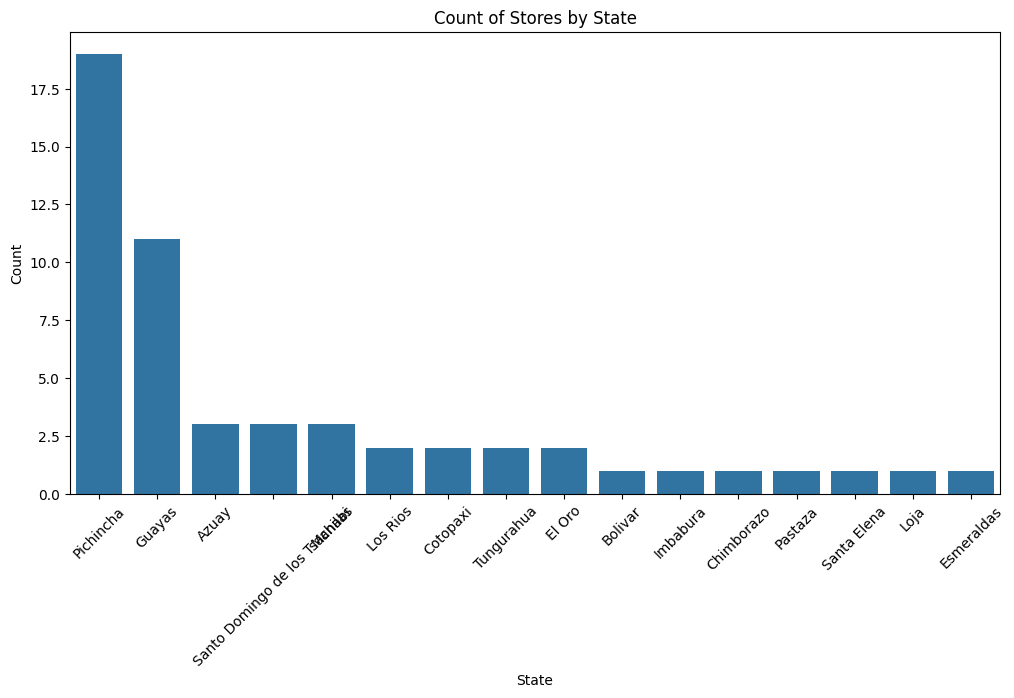

In [29]:
# Count of stores by state
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=df_stores, order=df_stores['state'].value_counts().index)
plt.title('Count of Stores by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


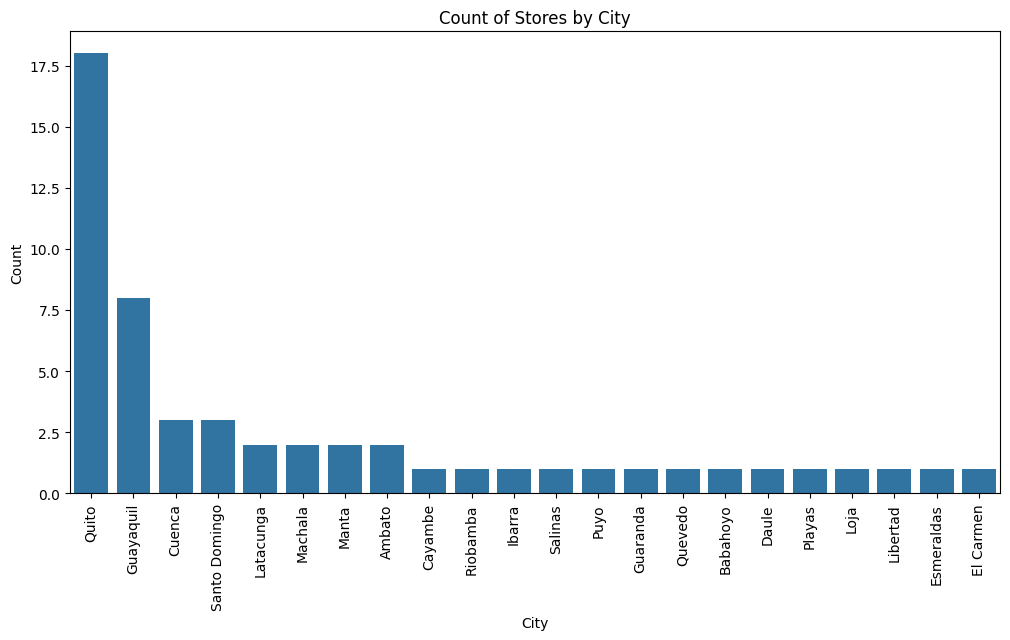

In [30]:
# Count of stores by city
plt.figure(figsize=(12, 6))
sns.countplot(x='city', data=df_stores, order=df_stores['city'].value_counts().index)
plt.title('Count of Stores by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


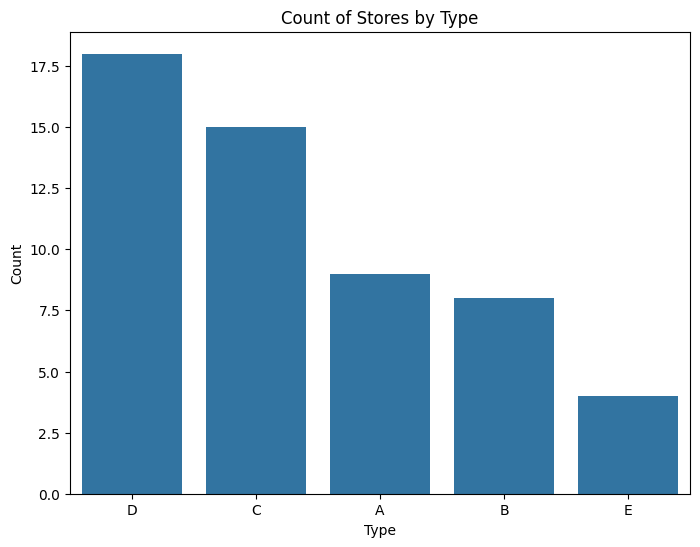

In [31]:
# Count of stores by type
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=df_stores, order=df_stores['type'].value_counts().index)
plt.title('Count of Stores by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()


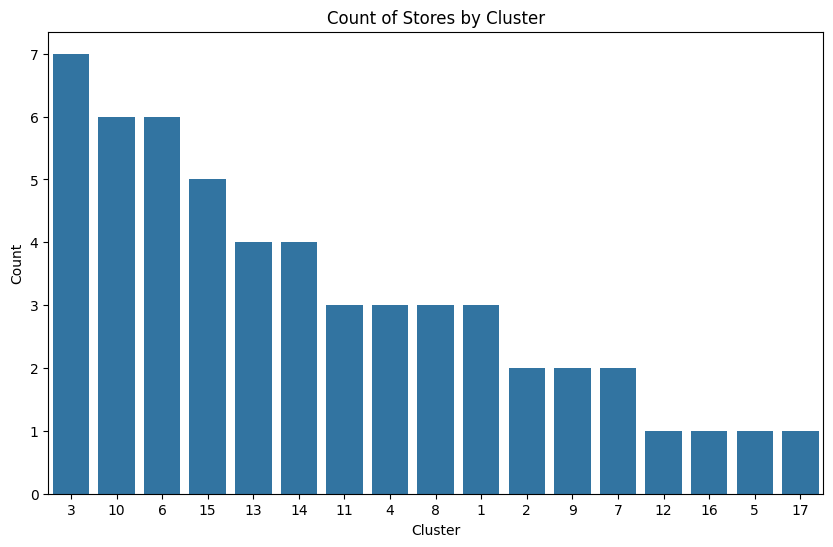

In [32]:
# Count of stores by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_stores, order=df_stores['cluster'].value_counts().index)
plt.title('Count of Stores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


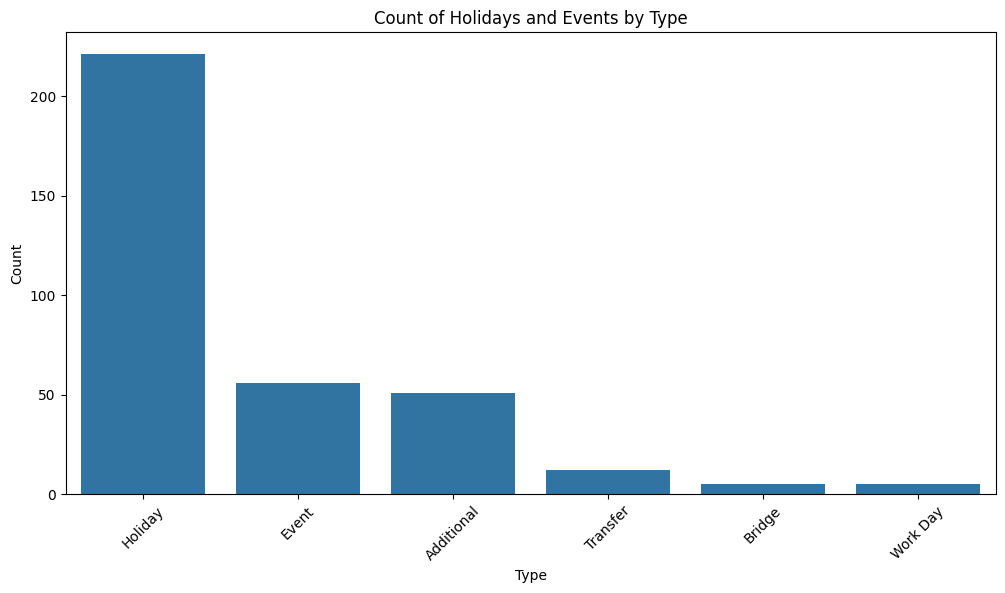

In [33]:
# Count of holidays and events by type
plt.figure(figsize=(12, 6))
sns.countplot(x='type', data=df_holidays_events, order=df_holidays_events['type'].value_counts().index)
plt.title('Count of Holidays and Events by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


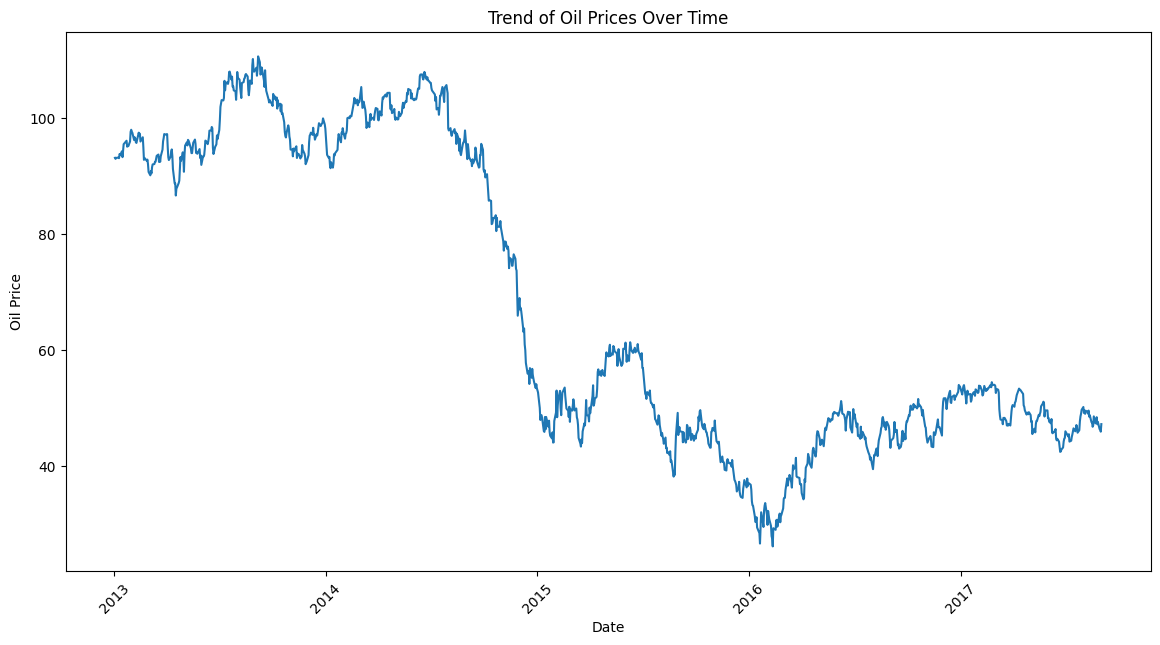

In [34]:
# Trend of oil prices
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='dcoilwtico', data=data_oil)
plt.title('Trend of Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.xticks(rotation=45)
plt.show()


#### **RENAMING COLUMNS**

In [35]:
# Rename the "dcoilwtico" column to "price"
oil_eda = data_oil.copy()
oil_eda.rename(columns={'dcoilwtico': 'price'}, inplace=True)

In [36]:
# Confirm changes
oil_eda.head()

,date,price
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


### **MERGING**

In [37]:
# Define a function that check the matching columns across all the dataset 

# Define a Class that assigns the name to the Dataset
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name

# Define a function that output the matching pairs
def find_matching_columns_in_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]

                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [38]:
# Define the dataset names
datasets = [
    (data_oil, 'Oil'),
    (df_holidays_events, 'Holidays Events'),
    (df_stores, 'Stores'),
    (transactions, 'Transactions'),
    (df_train, 'Train'),
    (df_test, 'Test'),
]

# Apply the function to check the pairs
find_matching_columns_in_pairs(datasets)

Matching columns between Oil and Holidays Events: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays Events and Stores: ['type']
Matching columns between Holidays Events and Transactions: ['date']
Matching columns between Holidays Events and Train: ['date']
Matching columns between Holidays Events and Test: ['date']
Matching columns between Stores and Transactions: ['store_nbr']
Matching columns between Stores and Train: ['store_nbr']
Matching columns between Stores and Test: ['store_nbr']
Matching columns between Transactions and Train: ['date', 'store_nbr']
Matching columns between Transactions and Test: ['date', 'store_nbr']
Matching columns between Train and Test: ['id', 'date', 'store_nbr', 'family', 'onpromotion']


In [39]:
# Define a function that compares the two dates and also check the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [40]:
# Apply the function to compare for Transaction and Train
compare_result_train= date_comparison(transactions['date'], df_train['date'])

# print
pd.DataFrame(compare_result_train)

,Common,Uncommon,Date Range 1,Date Range 2
0,1682,2,2013-01-01,2013-01-01
1,1682,2,2017-08-15,2017-08-15


In [41]:
# Apply the function to compare for Transaction and Test
compare_result_test= date_comparison(transactions['date'], df_test['date'])

# print
pd.DataFrame(compare_result_test)

,Common,Uncommon,Date Range 1,Date Range 2
0,0,1698,2013-01-01,2017-08-16
1,0,1698,2017-08-15,2017-08-31


In [42]:
# Merge the Stores data to the Train
train_eda = df_train.copy()
train_eda = train_eda.merge(oil_eda, on=['date'])

In [43]:
# Merge holidays events, stores and transactions to the Train
train_eda = train_eda.merge(df_stores, on=['store_nbr'])
train_eda = train_eda.merge(df_holidays_events, on=['date'])
train_eda = train_eda.merge(transactions, on=['date', 'store_nbr'])

In [44]:
# Confirm the merged columns to the train
train_eda.head()

,id,date,store_nbr,family,sales,onpromotion,price,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
1,562,2013-01-01,25,BABY CARE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
2,563,2013-01-01,25,BEAUTY,2.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
3,564,2013-01-01,25,BEVERAGES,810.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
4,565,2013-01-01,25,BOOKS,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770


In [45]:
# Rename the type_x and type_y
train_eda.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'}, inplace=True)

In [46]:
# Check for missing values
train_eda.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
price           22044
city                0
state               0
holiday_type        0
cluster             0
store_type          0
locale              0
locale_name         0
description         0
transferred         0
transactions        0
dtype: int64

In [47]:
# Get the rows and columns in the train dataset
train_eda.shape

(322047, 17)

In [48]:
# Get more info
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int8          
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  object        
 6   price         300003 non-null  float64       
 7   city          322047 non-null  object        
 8   state         322047 non-null  object        
 9   holiday_type  322047 non-null  object        
 10  cluster       322047 non-null  int64         
 11  store_type    322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [49]:
# Generate summary statistics
train_eda.describe()

,id,date,store_nbr,sales,price,cluster,transactions
count,3.220470e+05,322047,322047.000000,322047.000000,300003.000000,322047.000000,322047.000000
mean,1.682979e+06,2015-08-04 23:49:57.971104,26.994672,406.383452,64.077912,8.531202,1734.117840
min,5.610000e+02,2013-01-01 00:00:00,1.000000,0.000000,27.959999,1.000000,54.000000
25%,1.010616e+06,2014-07-23 00:00:00,13.000000,1.000000,44.660000,4.000000,1030.000000
50%,1.842406e+06,2015-11-02 00:00:00,27.000000,19.000000,51.439999,9.000000,1409.000000
75%,2.209556e+06,2016-05-27 00:00:00,40.000000,241.260505,94.739998,13.000000,2148.000000
max,3.000887e+06,2017-08-15 00:00:00,54.000000,124717.000000,107.949997,17.000000,8359.000000
std,7.862493e+05,NaN,15.595174,1246.881240,25.147682,4.713809,1050.335018


In [50]:
# Get the unique years contained in the dataset
train_eda['date'].dt.year.unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [51]:
# Confirm changes
train_eda.head()

,id,date,store_nbr,family,sales,onpromotion,price,city,state,holiday_type,cluster,store_type,locale,locale_name,description,transferred,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
1,562,2013-01-01,25,BABY CARE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
2,563,2013-01-01,25,BEAUTY,2.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
3,564,2013-01-01,25,BEVERAGES,810.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
4,565,2013-01-01,25,BOOKS,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770


In [52]:
# Set the index of the train to date to aid smooth analysis
train_eda.set_index('date', inplace=True)

In [53]:
# Convert onpromotion to int
train_eda['onpromotion'] = train_eda['onpromotion'].astype('int')

#### **Hpothesis Testing**

Null Hypothesis (H0): The number of products under promotion does not influence sales in supermarkets.

Alternative Hypothesis (H1): The number of products under promotion significantly influence sales in supermarkets.

In [54]:
# Extract the 'onpromotion' and 'sales' columns
onpromotion = train_eda['onpromotion']
sales = train_eda['sales']

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = stats.pearsonr(onpromotion, sales)

# Define the significance level (alpha)
alpha = 0.05

# Print the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

# Check if the correlation is statistically significant
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant influence of onpromotion on sales.")
else:
    print("Fail to reject the null hypothesis. There is no significant influence of onpromotion on sales.")

Pearson Correlation Coefficient: 0.4180
P-value: 0.0000
Reject the null hypothesis. There is a significant influence of onpromotion on sales.


In [62]:
print(train_eda.columns)

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion', 'price',
       'city', 'state', 'holiday_type', 'cluster', 'store_type', 'locale',
       'locale_name', 'description', 'transferred', 'transactions'],
      dtype='object')


### **ANSWERING ANALYTICAL QUESTIONS**

1. IS THE TRAIN DATASET COMPLETE (HAS ALL THE REQUIRED DATES)?

In [55]:
# reset train data index
train_eda.reset_index(inplace=True)

# Compute minimum and maximum dates
min_date = train_eda['date'].min()
max_date = train_eda['date'].max()
all_dates = pd.date_range(start=min_date, end=max_date)
missing_dates = all_dates[~all_dates.isin(train_eda['date'])]

if missing_dates.empty:
    print("The train dataset is complete for all required dates.")
else:
    print("The train dataset is not complete for all required dates. Missing dates: \n", missing_dates)

The train dataset is not complete for all required dates. Missing dates: 
 DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1509, freq=None)


2. WHICH DATES HAVE THE LOWEST AND HIGHEST SALES FOR EACH YEAR?

In [63]:
train_eda['year'] = train_eda['date'].dt.year
min_sales_dates = train_eda.groupby('year')[['date', 'sales']].min()
max_sales_dates = train_eda.groupby('year')[['date', 'sales']].max()
full_dates = min_sales_dates.merge(max_sales_dates, on=['year'])

In [64]:
min_sales_dates = train_eda.groupby('year')[['date', 'sales']].min()
max_sales_dates = train_eda.groupby('year')[['date', 'sales']].max()

full_dates = min_sales_dates.merge(max_sales_dates, on=['year'])

full_dates.rename(columns={'date_x': 'date_min', 'sales_x': 'sales_min', 'date_y': 'date_max', 'sales_y': 'sales_max'},  inplace=True)

full_dates

,date_min,sales_min,date_max,sales_max
year,,,,
2013,2013-01-01,0.0,2013-12-31,46271.0
2014,2014-01-01,0.0,2014-12-31,45361.0
2015,2015-01-01,0.0,2015-12-31,33274.0
2016,2016-02-08,0.0,2016-12-26,124717.0
2017,2017-01-02,0.0,2017-08-15,23966.0


3. DID THE EARTHQUAKE IMPACT SALES?

In [69]:
# Filter data for the period before and after the earthquake
pre_earthquake = train_eda[train_eda['date'] < '2016-04-16']
post_earthquake = train_eda[train_eda['date'] >= '2016-04-16']

In [74]:
# Create a line plot for sales
fig = px.line(train_eda, x='date', y='sales', title='Supermarket Sales Over Time')

# Earthquake date
earthquake_date = '2016-04-16'

# Add a vertical line at the date of the earthquake
fig.add_shape(
    go.layout.Shape(
        type='line',
        x0=earthquake_date,
        x1=earthquake_date,
        y0=0,
        y1=train_eda['sales'].max(),
        line=dict(color='red', width=2, dash='dash'),
    )
)

# Show plot
plt.show()

#### **STATISTICAL ANALYSIS**

In [71]:
# Perform a t-test to compare sales before and after the earthquake
t_stat, p_value, _ = ttest_ind(pre_earthquake['sales'], post_earthquake['sales'])

# Significance level
alpha = 0.05

if p_value < alpha:
    print(f"The difference in sales before and after the earthquake is statistically significant (p-value = {p_value}).")
else:
    print(f"There is no statistically significant difference in sales before and after the earthquake (p-value = {p_value}).")

The difference in sales before and after the earthquake is statistically significant (p-value = 5.925430444033457e-125).


4. ARE CERTAIN GROUPS OF STORES SELLING MORE PRODUCTS? (CLUSTER, CITY, STATE, TYPE)

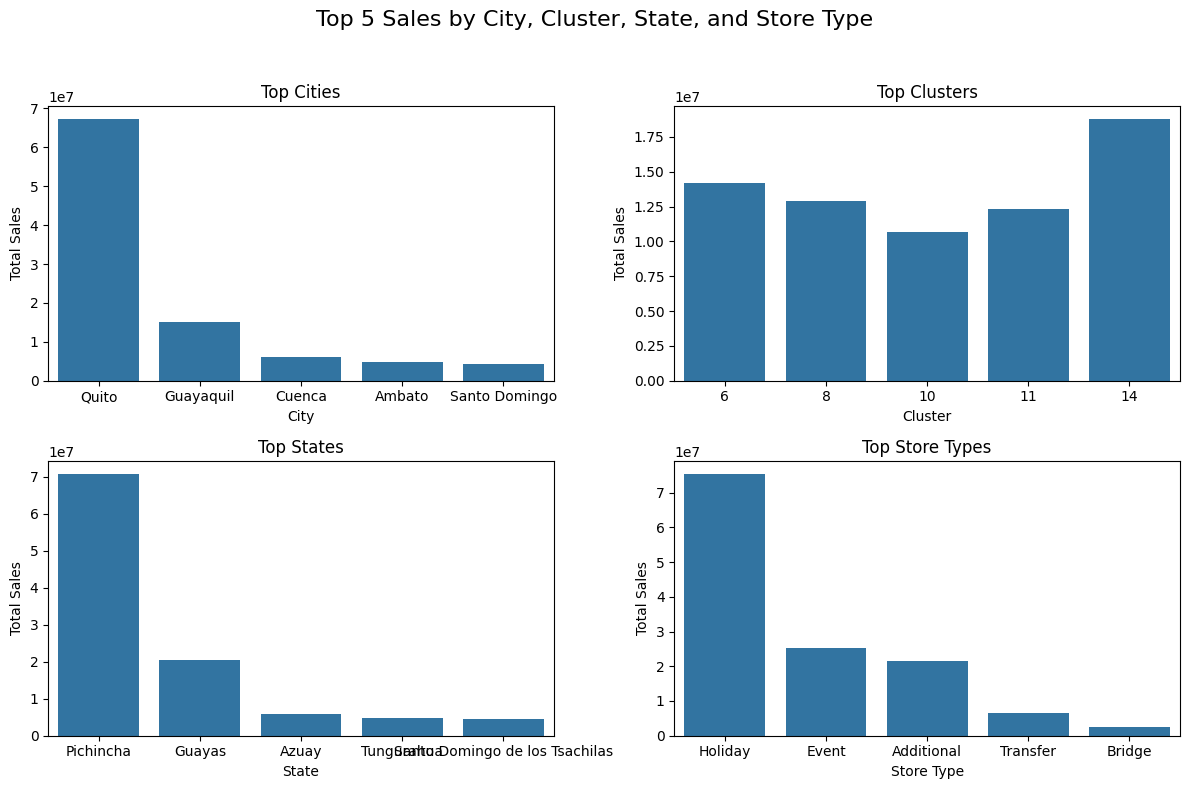

In [61]:
# Calculate total sales for the top 5 cities, clusters, states, and store types
top_cities = train_eda.groupby('city')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_clusters = train_eda.groupby('cluster')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_states = train_eda.groupby('state')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_store_types = train_eda.groupby('store_type')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Top 5 Sales by City, Cluster, State, and Store Type', fontsize=16)

# Add bar graphs for top cities
sns.barplot(data=top_cities, x='city', y='sales', ax=axes[0, 0])
axes[0, 0].set_title('Top Cities')
axes[0, 0].set_xlabel('City')
axes[0, 0].set_ylabel('Total Sales')

# Add bar graphs for top clusters
sns.barplot(data=top_clusters, x='cluster', y='sales', ax=axes[0, 1])
axes[0, 1].set_title('Top Clusters')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Total Sales')

# Add bar graphs for top states
sns.barplot(data=top_states, x='state', y='sales', ax=axes[1, 0])
axes[1, 0].set_title('Top States')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Total Sales')

# Add bar graphs for top store types
sns.barplot(data=top_store_types, x='store_type', y='sales', ax=axes[1, 1])
axes[1, 1].set_title('Top Store Types')
axes[1, 1].set_xlabel('Store Type')
axes[1, 1].set_ylabel('Total Sales')

# Adjust subplot layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

### **DATA SAMPLING**

In [75]:
# Define a function to perform the sampling
def data_sample(df, size):
    """
    Randomly samples rows from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame from which to sample.
    - size (float): The proportion of rows to sample (e.g., 0.1 for 10%).

    Returns:
    - pd.DataFrame: A randomly sampled subset of the input DataFrame.
    """
    # Set a seed for reproducibility (optional)
    random.seed(42)

    # Calculate the number of rows to sample based on the specified proportion
    sample_size = int(size * len(df))

    # Randomly select rows to create a sample
    sampled_data = df.sample(n=sample_size)

    return sampled_data

In [76]:
# Apply the function to sample the 40%
sampled_train = data_sample(train_eda, 0.4)

In [77]:
# Confirm changes
sampled_train.shape

(128818, 18)

HANDLING MISSING VALUES

In [78]:
# Check for the null values in the price data
train_eda['price'].isnull().sum()

np.int64(22044)

In [79]:
# Get the price column
oil_price = train_eda.set_index('date')['price']

# Apply time-based interpolation
oil_price_interpolated = oil_price.interpolate(method='index')

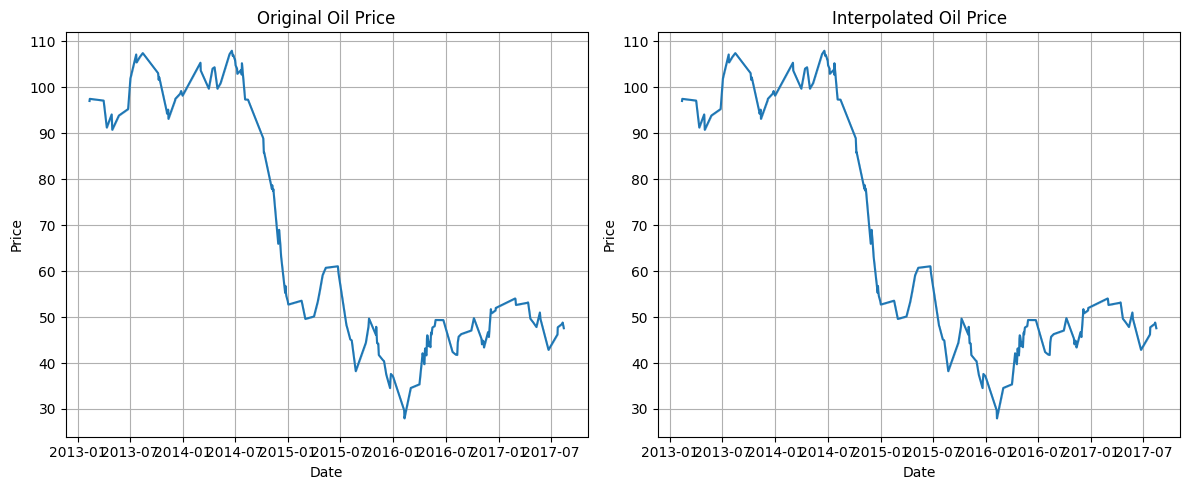

In [80]:
# Confirm changes by plotting the price with the missing values and price interpolated

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the original oil price data
sns.lineplot(data=oil_price, ax=axes[0])
axes[0].set_title('Original Oil Price')

# Plot the interpolated oil price data
sns.lineplot(data=oil_price_interpolated, ax=axes[1])
axes[1].set_title('Interpolated Oil Price')

# Add labels and adjust layout
for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)

plt.tight_layout()

# Show plot
plt.show()

From the above plot, the interpolation method shows consistent and good result and maintains data integrity

#### **DATA MERGING FOR MODELING AND PREDICTIONS**

Given the incomplete nature of the previously used transaction dataset during exploratory data analysis, we will now merge the various datasets once more to ensure a seamless modeling process.

In [81]:
# Merge Stores with Train on store_nbr
df_merged = df_train.merge(df_stores, on='store_nbr', how='left')

In [82]:
# Merge Oil on date
df_merged = df_merged.merge(data_oil, on='date', how='left')

In [83]:
# Merge holidays_events on 'date'
df_merged = df_merged.merge(df_holidays_events, on='date', how='left')

In [84]:
# Fill in missing values introduced by the merging
df_merged[['type_y', 'locale', 'locale_name']] = df_merged[['type_y', 'locale', 'locale_name']].fillna('NoHoliday')
df_merged['transferred'] = df_merged['transferred'].fillna(False)

In [85]:
# Confirm changes
df_merged.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [86]:
# Convert onpromotion column to numeric
df_merged['onpromotion'] = pd.to_numeric(df_merged['onpromotion'], errors='coerce')

In [103]:
# Calculate the correlation matrix

# Select numeric columns
numeric_df = df_merged.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=custom_color_palette)
plt.title('Correlation Matrix')
plt.show()

NameError: name 'custom_color_palette' is not defined

<Figure size 1000x800 with 0 Axes>

In [90]:
# Set 'id' column as the index
df_merged.set_index('id', inplace=True)

In [91]:
# Columns to drop
columns_to_drop = [ 'city', 'state', 'type_x', 'dcoilwtico', 'type_y', 'locale', 'locale_name', 'transferred']

# Drop the columns
df_merged = df_merged.drop(columns=columns_to_drop)

In [92]:
# Rearrange columns to make 'sales' the last column
cols = [col for col in df_merged.columns if col != 'sales'] + ['sales']
df_merged = df_merged[cols]

In [93]:
# Aggregating data
df_family_aggregated = df_merged.groupby(['date', 'family']).agg({ 'sales': 'sum', 'onpromotion': 'sum' }).reset_index()

In [94]:
df_family_aggregated.isnull().sum()

date           0
family         0
sales          0
onpromotion    0
dtype: int64

### **FEATURE ENGINEERING**

In [95]:
# Create day of the week feature
df_family_aggregated['day_of_week'] = df_family_aggregated['date'].dt.dayofweek

# Lag sales by 1 to get the previous day sales value
df_family_aggregated['lag_1'] = df_family_aggregated['sales'].shift(1)

# Add rolling mean with a 7-day window 
df_family_aggregated['rolling_mean'] = df_family_aggregated['sales'].rolling(window=7).mean()

In [96]:
# Check for mising values
df_family_aggregated.isnull().sum()

date            0
family          0
sales           0
onpromotion     0
day_of_week     0
lag_1           1
rolling_mean    6
dtype: int64

In [97]:
# Drop all Missing values introduced due to lag and rolling mean
df_family_aggregated.dropna(inplace=True)

In [98]:
# Get the rows and columns
df_family_aggregated.shape


(55566, 7)

After conducting feature engineering, our dataset has transformed to dimensions (55566, 7). The new features and modifications introduced through this process are expected to provide additional insights and predictive power for our models. With these enhancements, we are better equipped to build and evaluate more accurate forecasting models.

### **DATA PREPROCESSING**

In [99]:
df_family_aggregated.head()

,date,family,sales,onpromotion,day_of_week,lag_1,rolling_mean
6,2013-01-01,CELEBRATION,0.00,0,1,180.589,141.798429
7,2013-01-01,CLEANING,186.00,0,1,0.000,168.369857
8,2013-01-01,DAIRY,143.00,0,1,186.000,188.798429
9,2013-01-01,DELI,71.09,0,1,143.000,198.668429
10,2013-01-01,EGGS,46.00,0,1,71.090,89.525571


In [100]:
# Define a high level function to preprocess the data 
def preprocess_data(df: pd.DataFrame):
    
    # Separate Categorial and Numerical Columns
    cat_col = df.select_dtypes('object').columns
    num_col = df.select_dtypes('number').columns

    # Save a copy of the date column
    original_date = df['date'].copy()

    # Define the preprocessing steps using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer([
        ('scaler', MinMaxScaler(), num_col),
        ('encoder', OneHotEncoder(handle_unknown='ignore', categories='auto', sparse=False), cat_col),
    ], remainder='passthrough')

    # Fit the preprocessor to the data while the date is dropped
    preprocessor.fit(df.drop('date', axis=1))

    # Transform the data to get the preprocessed data
    preprocessed = preprocessor.transform(df.drop('date', axis=1))

    # Get the various transformers
    encoder = preprocessor.named_transformers_['encoder']
    scaler = preprocessor.named_transformers_['scaler']

    # Access the feature names using the get_feature_names_out() method
    encoded_feature_names = encoder.get_feature_names_out(input_features=cat_col)
    scaled_feature_names = scaler.get_feature_names_out(input_features=num_col)

    # Form a list of all features
    all_feature_names = list(scaled_feature_names) + list(encoded_feature_names) 

    # Create a DataFrame and add the column names
    preprocessed_df = pd.DataFrame(preprocessed, columns=all_feature_names)

    # Set the index of the DataFrame to the original date
    preprocessed_df.index = original_date

    # Sort the DataFrame by date
    preprocessed_df = preprocessed_df.sort_index().reset_index()

    # Return the preprocessed data and the preprocessor
    return preprocessed_df, preprocessor

In [102]:
# Apply the function to get the preprocessed data
train_preprocessed_df, _ = preprocess_data(df_family_aggregated)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'